
# Session 14: Text data
#### Introduced by Terne Sasha Thorn Jakobsen
We introduce the concept of **Text as Data**, and apply our newly acquired knowledge of supervised learning to a text classification problem.


## Lecture videos

View the videos and follow along in this notebook, which I go through in the videos!

Part 1,  Intro and preprocessing: https://youtu.be/Gv7IU18hbXw

Part 2, Lexicons for sentiment analysis: https://youtu.be/B_5k_QkCHLI 

Part 3, Feature extraction: https://youtu.be/HV3Vl-P3kqs 

Part 4, Text classification: https://www.youtube.com/watch?v=0RYmNQwnhOE&feature=youtu.be


#### Required readings
 
- PML: following sections from chapter 8:
  - Preparing the IMDb movie review data for text processing
  - Introducing the bag-of-words model
  - Training a logistic regression model for document classification
 
Gentzkow, M., Kelly, B.T. and Taddy, M., 2017. ["Text as data"](http://www.nber.org/papers/w23276.pdf) (No. w23276). *National Bureau of Economic Research*.

Jurafsky, D., & Martin, J. H. (2019). Vector Semantics and Embeddings. Speech and Language Processing, 3rd ed. draft. https://web.stanford.edu/~jurafsky/slp3/6.pdf

*(PML) Raschka, Sebastian, and Mirjalili, Vahid. Python Machine Learning - Second Edition. Birmingham: Packt Publishing, Limited, 2017. Chapter 8*


#### Inspirational readings

Gorrell, Genevieve et al. “Twits, Twats and Twaddle: Trends in Online Abuse towards UK Politicians.” ICWSM (2018). https://gate-socmedia.group.shef.ac.uk/wp-content/uploads/2019/07/Gorrell-Greenwood.pdf

Pang, Bo et al. “Thumbs up? Sentiment Classification using Machine Learning Techniques.” EMNLP (2002). https://www.aclweb.org/anthology/W02-1011.pdf 







Course page: https://abjer.github.io/isds2020

## Motivation


Why work with text data... Huge amount of data! 

May teach us about:
- how we communicate with eachother
- public opinions (e.g. towards politicians, reflecting who we are going to vote for)
- general knowledge: we can extract information and knowledge from documents, and we can summarize information from large corpuses to just a few lines of text if needed.

**Agenda**
- Preprocessing text
- Lexicons
- Feature extraction
- Text classification

## Import packages

In [ ]:
!pip install pyprind

In [ ]:
!pip install afinn
!pip install vaderSentiment

In [ ]:
# from the textbook, for printing a process bar.
import pyprind

# basic packages
import pandas as pd
import os
import numpy as np
import re # python regular expressions
import string # for efficient operations with strings
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK: A basic, popular NLP package. Find many examples of applications at https://www.nltk.org/book/
# Install guide: https://www.nltk.org/install.html
import nltk
nltk.download('punkt') # you will probably need to do this
nltk.download('wordnet') # and this
nltk.download('stopwords') # aand this
nltk.download('sentiwordnet')

# for vectorization 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Vader Lexicon for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# similarity/distance measures
from scipy.spatial import distance
from sklearn.metrics.pairwise import linear_kernel

# for classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Lexicons for sentiment analysis
from vaderSentiment import vaderSentiment
from afinn import Afinn

# to display images in notebook
from IPython.display import Image

## Preparing data (following PML chapter 8)

Data source:

Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

Download from http://ai.stanford.edu/~amaas/data/sentiment/. (just click the link and put the files in the same folder as the notebook).


If you are a mac user you can also just:

In [ ]:
# download the data with wget (for mac users. Windows users just click the link above)
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz


In [ ]:
# unpack
import tarfile
with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as tar:
    tar.extractall()

In [ ]:
# load data into a pandas DataFrame

basepath = "aclImdb"

labels = {"pos":1, "neg":0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ("test", "train"):
    for l in ("pos", "neg"):
        path = os.path.join(basepath,s,l)
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path,file), "r", encoding="utf-8") as infile:
                txt = infile.read()
            # Here I also append s ("train" or "test") to later use the predefined 
            # split of the data. They didn't do this in the textbook.
            df = df.append([[txt, labels[l], s]], ignore_index=True) 
            pbar.update()
df.columns = ["review", "sentiment", "set"]

In [ ]:
df # look at the dataframe

In [ ]:
# dividing into train and test set again.
df_train = df[df.set=="train"]
df_test = df[df.set=="test"]

# Permute data such that pos and neg samples are mixed

np.random.seed(0)
df_train = df.reindex(np.random.permutation(df_train.index))
df_test = df.reindex(np.random.permutation(df_test.index))

# save dataframes:
df_train.to_csv("train.csv", index=False)
df_test.to_csv("test.csv", index=False)

In [ ]:
# load saved dataframes:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.head()

## Preprocessing
 herein text normalization (i.e. standardizing the text format)

### Tokenization (segmentation)

In [ ]:
sentence = df_train.review.values[0]
print(sentence)
 
# word tokenization (segmentation)
# by blank space (crude)
sent = sentence.split(" ")
print(sent)
# by using a package such as NLTK.
sent = nltk.tokenize.word_tokenize(sentence)
print()
print(" NLTK word tokenization: ", sent)
# nltk.tokenize.TweetTokenizer() is another option, and good for social media text.

# Sentence segmentation (sentence splitting)
sents = nltk.tokenize.sent_tokenize(sentence)
print()
print("Sent tokenization", sents)

# There are many other more complex versions used for specific cases/tasks/models and sometime you may want to costumize the segmentation.
# Learn more: https://web.stanford.edu/~jurafsky/slp3/2.pdf

### Stemming or lemmatising

**Stemming**: Stripping the word down to it's central meaning (it's stem) by removing affixes. Stemming usually only removes suffixes (i.e. affixes at the end of the words).

E.g.: 

sings --> sing

laughing --> laugh

wonderful --> wonder


**Lemmatizing**: "the task of determining that two words have the same root, despite their surface differences. For example, the words sang, sung, and sings are forms of the verb sing. The word sing is the common lemma of these words, and a lemmatizer maps from all of these to sing." (Jurafsky, D., & Martin, J. H., 2019. Chap. 2, p. 2)


In [ ]:
def stem(word):
    # find suffixes and return stems
    # (.*?) matches any character in front of a word (non greedy version)
    regexp = r'^(.*?)(ing|ly|ed|ious|ies|ive|es|s|ment)?$'
    stem, suffix = re.findall(regexp, word)[0]
    return stem

# Tokenize the text first
tokens = nltk.word_tokenize(sentence)
#print(tokens)

print([stem(t) for t in tokens]) # hmm not so good

In [ ]:
# using NLTK's Porter stemmer
porter = nltk.PorterStemmer()
#print(sentence)
print([porter.stem(t) for t in tokens])

In [ ]:
# using the WordNet lemmatizer through NLTK
# WordNet is a large lexical database of English (think "lexicon")
wnl = nltk.WordNetLemmatizer()
#print(sentence)
print([wnl.lemmatize(t) for t in tokens])
# note the differences.. this lemmatizer knows that the word "based" does not have the same meaning as "base" here. 
# Seems more comprehensible. Or lot less has actually changed. (examples: "goes" became "go" and "villagers" became "villager")

### Casing, stopwords, punctuation etc.

In [ ]:
# Casing (lower casing is normal procedure such that the word "That", after a punctuation, and "that" are not treated as two seperate features.
sent = sentence.lower()
print(sent)
# Note: you may want some exceptions, e.g. distinction between US and us can be important for some tasks.


# lowercase and then tokenize all texts in the training set – in one list comprehension:
train_sents = [nltk.word_tokenize(i.lower()) for i in df_train.review.values]
print(train_sents[0])
# And do the same with the test set
test_sents = [nltk.word_tokenize(i.lower()) for i in df_test.review.values]


In [ ]:
# Removing certain words (stopwords)
stop_words_list = nltk.corpus.stopwords.words("english")
print(stop_words_list)
print()
sent_sw_removed = [i for i in nltk.word_tokenize(sentence.lower()) if i not in stop_words_list]
print(sent_sw_removed)
#train_sents_sw_removed = [[i for i in sent if i not in stop_words_list] for sent in train_sents] # nested list comprehension; lists in list.
#test_sents_sw_removed = [[i for i in sent if i not in stop_words_list] for sent in test_sents]
#print(train_sents_sw_removed[0])

# unfortunately the tokenization does not totally align with the stopwords – the simple split at whitespace may be more appropiate before stopword removal.


In [ ]:
# Removing punctuation, two ways:

punct_removed_1 = sentence.translate(str.maketrans('', '', string.punctuation))
print(punct_removed_1)

#def removePunctuation (word):
#    return re.sub("[^\w\s\-\']", "", word)

punct_removed_2 = re.sub(r'[^\w\s]','',sentence) # learn more about regex at https://www.datacamp.com/community/tutorials/python-regular-expression-tutorial or find a cheat sheet.
print(punct_removed_2)

### Exercise 1: preprocessing
Make a preprocessing function that takes a single string and 
 1) Lowercase the words,
 2) split the text into words (tokenize), 
 3) either stem or lemmatize words.
Feel free to add more steps of preprocessing. For example stopword removal or removal of what seems to be HTML elements (such as "< br/>") in the text, and removal of punctuation, and handling of emoticons as in the textbook.

In [ ]:
def preprocess(text):
    # YOUR CODE HERE
    return lemmas # return a list of stems/lemmas

print(preprocess(sentence))


In [ ]:
# Have a look at the size of the vocabulary of the train data that 
# has only been lower-cased and tokenized (a few cells above).

all_words = []
for i in train_sents:
    all_words.extend(i)
V = set(all_words)
print(len(all_words))
print(len(V))


# Now do it yourself with your train data after preprocessing:

# YOUR CODE HERE

In [ ]:
sorted(V)

Notes: without preprocessing we see a lot of "words" in the vocabulary that are not words. This is a lesson in how important it is to look at your (training!) data.
Consider altering your preprocessing if you notice many mistakes in the vocab.

## Lexicons for sentiment analysis 

### Vader 

In [ ]:
# Vader lexicon
analyser = vaderSentiment.SentimentIntensityAnalyzer()
snt = analyser.polarity_scores(sentence)
#print(sentence)
print(snt)
compound = snt["compound"] # how to scoring works: https://github.com/cjhutto/vaderSentiment#about-the-scoring

### Afinn 

In [ ]:
# Afinn lexicon
afn = Afinn(emoticons=True)
print(afn.score(sentence))


In [ ]:
example_neg = "congrats on making an all-together predictable movie"
example_pos = "OMG I literally died!"

print(afn.score(example_neg))
print(afn.score(example_pos))


### SentiWordNet 

In [ ]:
# lexicon can be accessed with NLTK:
good = nltk.corpus.sentiwordnet.senti_synsets('good', 'a') # a=adjective,n=noun
for i in good:
    print(i)
print()

print("good.a.01 Definition: ", nltk.corpus.wordnet.synset('good.a.01').definition())

print("good.s.20 Definition: ", nltk.corpus.wordnet.synset('good.s.20').definition())

print("good.a.03 Definition: ", nltk.corpus.wordnet.synset('good.a.03').definition())

## Feature representation/extraction

### BoW (Bag of Words)

- Represent the texts with a **Term-Document frequency matrix** where each text is represented by a vector of word counts. n_samples x n_features matrix. n_features=size of vocabulary.

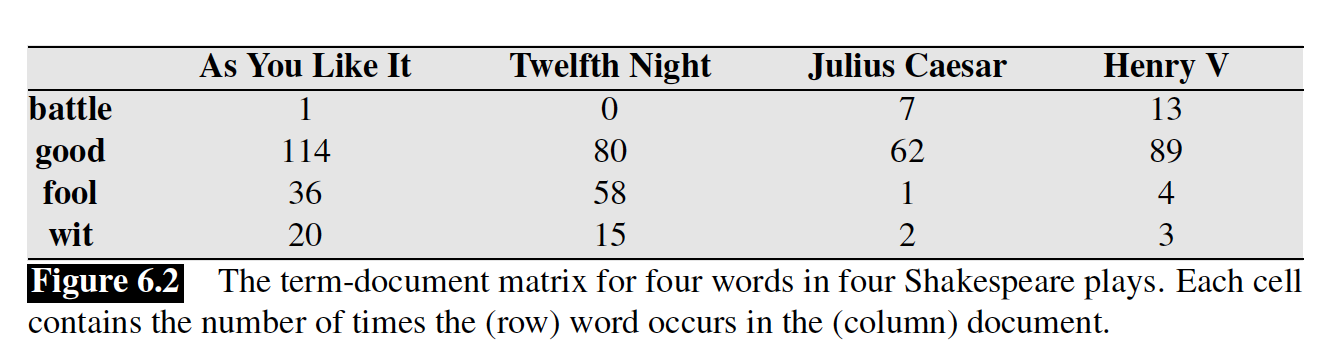

In [52]:
Image("term_document.png") # (Jurafsky, D., & Martin, J. H., 2019. Chap. 6, p. 7)

In [ ]:
# CountVectorizer has a build-in tokenizer and lowercases by default. Also has an option to remove stopwords.
vectorizer = CountVectorizer()
# However, you can override the default tokenization with your own defined function, like so:
#vectorizer = CountVectorizer(tokenizer=preprocess)

# fit and transform train
X_train_bow = vectorizer.fit_transform(df_train.review.values)
# Only tranform test: never fitting your vectorizer on the test set (it is cheating). OOV words are handled automatically be sklearn's vectorizer.
X_test_bow = vectorizer.transform(df_test.review.values)

In [ ]:
print(X_train_bow.shape)
print(len(vectorizer.vocabulary_))
X_train_bow[0]

Only 238 nonzero elements in the vector of the first text, i.e. 238 unique features/words out of 74,849.

In [ ]:
X_train_bow[0].toarray()

#### N-grams 

- Collection of 1 or more tokens.

- Bag of words lacks word order and context (semantics). n-grams to the rescue!

In [ ]:
example = "The cat in the hat"

In [ ]:
def make_ngrams(sentence,n):
    tokens = sentence.split(" ")
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

print("Unigrams:",make_ngrams(example,1))
print("Bigrams:",make_ngrams(example,2))
print("Trigrams:",make_ngrams(example,3))
print("4-grams:",make_ngrams(example,4))
print("5-grams:",make_ngrams(example,5))

In [ ]:
# n=1-5
vectorizer = CountVectorizer(ngram_range=(1,5)) #tokenizer=preprocess)

X_train_5gram = vectorizer.fit_transform(df_train.review.values)

In [ ]:
print(X_train_5gram.shape)
X_train_5gram[0]

- But now we have problems with high dimensionalty and uniqeness of features!

- N-grams are used for many applications but are especially known from **Language Models**: In short, probalistic models that learn to predict the next word in a sequence of words, given the "history" (the previous words), simply by storing the probability of this event occuring in the given text, e.g. P(hat|The cat in the). But instead of using ALL previous word (which would be a combination of words unique to the given text), the history is approximated by a few previous words (n-grams), e.g. P(hat|the). This is the n-gram language model.



### Term Frequency–Inverse Document Frequency (TF-IDF)

The tf-idf value of term t in document d is:

TF-IDF(t,d) = tf(t,d) x idf(t)

where,

tf(t,d) = count of term t in document d

N = total number of documents

df(t) = number of documents that term t occurs in

idf(t) = N/df(t)

A "term" is a token in our case.

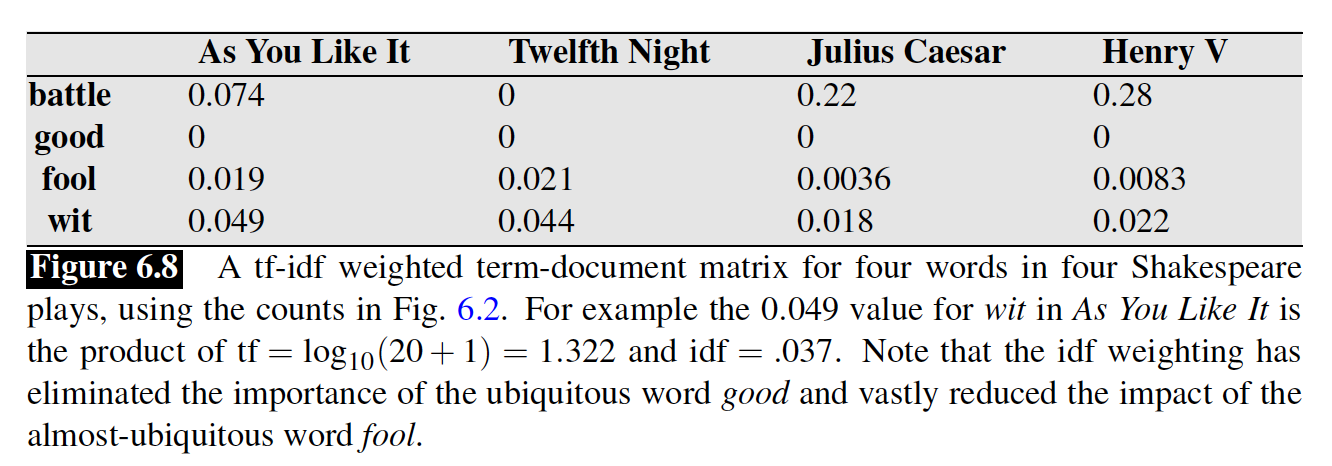

In [53]:
Image("tf_idf.png") # (Jurafsky, D., & Martin, J. H., 2019. Chap. 6, p. 14)

In [54]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(df_train.review.values)

#### Document similarity with tf-idf vectors

In [ ]:
#1-distance.cosine(X_train_tfidf[0].toarray(), X_train_tfidf[1].toarray())

In [55]:
# https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
cosine_similarities = linear_kernel(X_train_tfidf[0], X_train_tfidf).flatten()

indices = cosine_similarities.argsort()[::-1] # in descending order 
print("most similar:",indices[:10])
print("least similar", indices[-9:])

most similar: [    0 23558 23470 17790  4719 24385 20550  6001  6096 20886]
least similar [14867 11975 17497  5623  9340 14494 18802 16480 23603]


In [57]:
#print(df_train.review.values[0])
print()
print("most similar: ", df_train.review.values[23558])
print()
print("least similar: ", df_train.review.values[23603])


most similar:  Okay, so I'm not a big video game buff, but was the game House of the Dead really famous enough to make a movie from? Sure, they went as far as to actually put in quick video game clips throughout the movie, as though justifying any particular scene of violence, but there are dozens and dozens of games that look exactly the same, with the hand in the bottom on the screen, supposedly your own, holding whatever weapon and goo-ing all kinds of aliens or walking dead or snipers or whatever the case may be.<br /><br />It's an interesting premise in House of the Dead, with a lot of college kids (LOADED college kids, as it were, kids who are able to pay some fisherman something like $1,500 just for a ride after they miss their boat) trying to get out to this island for what is supposed to be the rave of the year. The first thing that comes to mind about House of the Dead after watching it is that it has become increasingly clear that modern horror movies have become nothing mo

### Vector semantics / Vector Space Models / (word) embeddings

Semantics: The *meaning* or catagory of a word.

Context is important to understand a word and give it a descriptive representation (encoding it's meaning). 

Assumption/intution: Two words are similar if they appear in similar contexts.


Word2Vec architectures:

- CBOW: Learn word embeddings by predicting a focus word given a context

- Skip-gram: Learn word embeddings by predicting context words given focus word

(https://arxiv.org/pdf/1301.3781.pdf ,
https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf, https://radimrehurek.com/gensim/models/word2vec.html)

In [58]:
from gensim.models import Word2Vec

# using the train_sents from earlier (the lowercased and tokenized sentences)
model = Word2Vec(train_sents, size=50)



In [59]:
print(model.wv['good'])

[ 0.41097444 -2.4785743  -0.13446975 -2.9085789   0.5847944   0.13734521
 -3.4491785   0.8171097   4.611036   -2.103263    1.5641267   3.1511762
 -2.586497   -0.26931274  1.006557    0.26577    -0.8349232   0.39527625
  3.0184116   0.05559673  0.69905263 -2.0228162   0.4306074   1.6089842
 -3.8544455   1.5749825   3.5800512  -3.9197924  -1.801474    1.4184997
  1.207257    0.901654    2.4797647  -1.6185853  -2.5804365  -2.3656254
 -1.8644211   1.1177346  -4.4675097  -0.3158954   0.9076118  -0.2573302
 -0.3497516   5.5682435   1.6602079   0.81694394  1.6521207   1.5880324
 -0.840914   -1.562373  ]


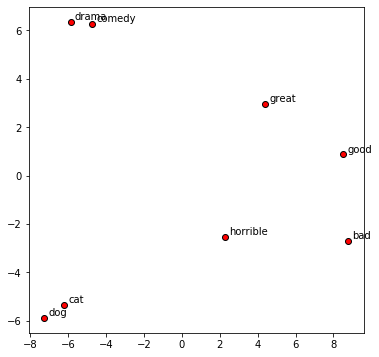

In [60]:
# Reducing the 50-dimensional vectors to 2 dimensions in order to visualise selected words.
from sklearn.decomposition import PCA

words = ["drama","comedy", "good", "great", "bad", "horrible", "cat", "dog"]

X = [model.wv['drama'], model.wv['comedy'], 
     model.wv['good'], model.wv['great'], 
     model.wv['bad'], model.wv['horrible'], 
     model.wv['cat'], model.wv['dog']]

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

plt.figure(figsize=(6,6))
plt.scatter(X_r[:,0], X_r[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(words, X_r):
    plt.text(x+0.2, y+0.1, word)

## Text classification

### Exercise 2: Lexicon-based sentiment classification (no Machine Learning)
Use the Vader lexicon to classify each review in the test set. Use the "compound" score where compound<=0 = negative review (0) and compound>0=positive review (1). Report the classification accuracy.

In [ ]:
#Your code here

### Text classification with logistic regression

In [62]:
# Get feature vectors
tfidf = TfidfVectorizer()
# use your own preprocessing function in the vectorizer when you've finished that exercise:
#tfidf = TfidfVectorizer(tokenizer=preprocess)
X_train_tfidf = tfidf.fit_transform(df_train.review.values)
X_test_tfidf = tfidf.transform(df_test.review.values)

# labels
y_train = df_train.sentiment.values
y_test = df_test.sentiment.values

# classifier
lr = LogisticRegression(random_state=0)

#training
lr.fit(X_train_tfidf,y_train)

#testing
train_preds = lr.predict(X_train_tfidf)
test_preds = lr.predict(X_test_tfidf)
print("training accuracy:", np.mean([(train_preds==y_train)]))
print("testing accuracy:", np.mean([(test_preds==y_test)]))


training accuracy: 0.93328
testing accuracy: 0.88316


#### Let's look at the features' coeffiecients

In [63]:
features = ['_'.join(s.split()) for s in tfidf.get_feature_names()]
coefficients = lr.coef_
coefs_df = pd.DataFrame.from_records(coefficients, columns=features)
coefs_df


,00,000,0000000000001,00001,00015,000s,001,003830,006,007,...,était,état,étc,évery,êxtase,ís,ísnt,østbye,über,üvegtigris
0,-0.096569,-0.305337,-0.033966,-0.038521,-0.005573,0.024453,-0.032348,0.031637,0.013828,0.056278,...,0.041276,0.047509,0.034055,-0.081397,0.016038,0.002182,-0.035297,0.01018,-0.084577,-0.053029


In [64]:
print(coefs_df.T.sort_values(by=[0], ascending=False).head(20))
print()
print(coefs_df.T.sort_values(by=[0], ascending=True).head(20))

                   0
great       7.597993
excellent   6.185474
best        5.127967
perfect     4.818600
wonderful   4.676444
amazing     4.164898
well        4.061736
loved       3.835260
fun         3.805573
today       3.782701
love        3.782314
favorite    3.743822
enjoyed     3.513010
highly      3.390157
brilliant   3.353821
it          3.330147
superb      3.321679
and         3.176546
definitely  3.031838
still       2.983629

                      0
worst         -9.242321
bad           -7.956060
awful         -6.493183
waste         -6.278238
boring        -6.020011
poor          -5.448303
terrible      -4.848693
nothing       -4.761642
worse         -4.577197
no            -4.394958
horrible      -4.208934
poorly        -4.167156
dull          -4.155190
unfortunately -3.984436
script        -3.871557
annoying      -3.827654
stupid        -3.818522
ridiculous    -3.668310
minutes       -3.600162
instead       -3.526372


### Exercise 3: 
Experiment with different features (counts and tf-idf) and n_gram ranges ((1,1), (1,2),(1,3) and (1,4)). 

Do 3-fold cross-validation using sklearn's GridSearchCV – as in the PML textbook (from page 268) – to see which combinations are best. Then, using this best combination, train a model with the full train set and test it on the test set. Report results. 

(Hint: You can use the parameter "use_idf" in the TfidfTransformer() – not vectorizer – to easliy test the usage of either just term frequencies or tf-idf frequencies).

In [ ]:
# YOUR CODE HERE

## Final exercise: Cross-domain evaluation

1. Download the Airline sentiment dataset here (you may need to login to download it): https://www.kaggle.com/crowdflower/twitter-airline-sentiment

General note on tweets: Tweets are messy (generally require a lot a of preproccesing if used to train a ML model).

2. Load the data into a dataframe named tweet_df. 

3. As you can see, the samples have three labels (neg, pos, neutral). You have to either relabel neutral tweets as positive or remove neutral tweets from the dataframe entirely.

4. Extract features from the tweets using the tf-idf vectorizer previously fitted on the Imdb review training data.

5. Use your previously trained logistic regression classifier and make predictions over your vectorized tweets. Report testing accuracy.

6. Finally, answer these questions:

    A) How well does your model perform in this other domain? 
    
    B) Can you identify the types of errors it makes? (hint: you can make a confusion matrix and you look at the words, and their respective coefficients, of relevant examples of misclassification). 
    
    C) Now, fit a new vectorizer and logistic regression classifier on the airline tweets (remove mentions, @user, as the very least amount of preprocessing. there are plenty of examples of how to do this with python regular expressions if you google it). What are the difference between most important features (high and low coeffiecients) between this model and your original model trained on the Imdb reviews? And what does this mean for the models' ability to generalize to new data?

In [ ]:
# YOUR CODE HERE

## Some NLP resources

**NLTK** (as we have seen): Basic NLP tools such as tokenization, stemming, lemmatization, part-of-speech tagging (though not as good as the one from stanfordNLP), dependency parsing. https://www.nltk.org. Good introductory material here: https://www.nltk.org/book/

**Wordnet**: A large lexicon of "synsets"; groups of words that are semantically closely related (synonyms). It can be used to infer word senses/meanings among other things https://wordnet.princeton.edu. 

**StanfordNLP (stanza)**: Tokenization, part-of-speech tagging, dependency parsing, named entity recognition, and more. https://stanfordnlp.github.io/stanza/.

**Spacy**: More advanced NLP pipelines for feature extraction and more https://spacy.io

**Gensim**: Popular models for word embeddings, e.g. word2vec and fastText, and more. https://radimrehurek.com/gensim/auto_examples/index.html


## Project inspiration

- Predicting election outcomes or market trends from sentiment
- Stance or sentiment towards political parties
- Hate speech detection
- Overaching topics in a debate (topic modelling)


## Summary


You've learned:
- What to consider when preprocessing text
- How to represent texts with numerical vectors
- That you can find similar texts by calculating the distance between their vectors.
- What word embeddings are and the basic intuition of it
- Possibilities with lexicons
- Binary text classification